This notebook contains the code for classical cluster counting algorithms. Also, a grid search of hyperparameters for adaptive clustering algorithm (ACA) and fixed clustering algorithm (FCA) is done. 

# Utilities

In [2]:
data_dir = "../data/"
results_dir = "../results/"
model_dir = "../models/"

In [3]:
import numpy as np
from numba import jit
@jit(nopython=True)
def _numba_peak_detection_single(waveform, d2, T1, T2):
    """Numba-compiled inner loop for single waveform processing."""
    n = len(waveform)
    peaks = []
    Int = np.zeros(n)
    
    for i in range(1, n):
        if waveform[i-1] < T1:
            continue
            
        if d2[i] > 0:
            Int[i] = Int[i-1] + d2[i]
        elif Int[i-1] > T2:
            peaks.append(i-1)
            Int[i] = 0.0
        else:
            Int[i] = 0.0

    return peaks


def numba_batched_derivative_peak_detection(waveforms, T1, T2):
    """
    Numba-accelerated derivative-based peak detection for multiple waveforms.
    
    Args:
    waveforms (np.array): 2D array where each row is a waveform (shape: [n_waveforms, n_points])
    T1 (float): Threshold for initial amplitude check.
    T2 (float): Threshold for integrated second derivative.
    
    Returns:
    list: List of detected peak indices for each waveform.
    """
    if len(waveforms.shape) == 1:
        waveforms = waveforms.reshape(1, -1)
    
    n_waveforms, n_points = waveforms.shape
    
    # Vectorized computation of derivatives
    D1 = np.zeros_like(waveforms)
    D1[:,1:] = np.maximum(np.diff(waveforms, axis=1), 0)
    mask = waveforms[:,:-1] < T1
    D1[:,1:][mask] = 0

    D2 = np.zeros_like(waveforms)
    D2[:,1:] = np.maximum(np.diff(D1, axis=1), 0)
    
    # Process each waveform using Numba
    all_peaks = []
    for w_idx in range(n_waveforms):
        peaks = _numba_peak_detection_single(waveforms[w_idx], D2[w_idx], T1, T2)
        all_peaks.append(list(peaks))  # Convert from numba list to Python list
    
    return all_peaks

In [4]:
import numpy as np
from tqdm import tqdm


def load_data(dir, files):
   # Dictionary to store lists of arrays for each key
   combined_data = {}


   # Loop through files and collect arrays
   for filename in files:
       origdata = np.load(dir+filename)
       for key in origdata.files:
           if key not in combined_data:
               combined_data[key] = []
           combined_data[key].append(origdata[key])


   # Concatenate arrays along the first axis for each key
   return {key: np.concatenate(arr_list, axis=0) for key, arr_list in combined_data.items()}


def derivative_peak_detection(waveform, T1, T2):
   """
   Derivative-based peak detection algorithm.
  
   Args:
   waveform (np.array): Input waveform with n points.
   T1 (float): Threshold for initial amplitude check.
   T2 (float): Threshold for integrated second derivative.
  
   Returns:
   list: Indices of detected peaks.
   """
   n = len(waveform)
   Output = []
   D1 = np.zeros(n)
   D2 = np.zeros(n)
   Int = np.zeros(n)
  
   for i in range(1, n):
       if waveform[i-1] < T1:
           continue
      
       D1[i] = max(waveform[i] - waveform[i-1], 0)
       D2[i] = max(D1[i] - D1[i-1], 0)
      
       if D2[i] > 0:
           Int[i] = Int[i-1] + D2[i]
       elif Int[i-1] > T2:
           Output.append(i-1)
           Int[i] = 0  # Reset integration after detecting a peak
       else:
           Int[i] = 0  # Reset integration if no peak detected
  
   return Output


def process_waveforms(waveforms, T1, T2):
   """
   Process multiple waveforms using the derivative algorithm.


   Returns:
       list: List of detected peak indices for each waveform.
   """
   all_peaks = []
   for waveform in tqdm(waveforms, desc="Processing waveforms", unit="waveform"):
       peaks = derivative_peak_detection(waveform, T1, T2)
       all_peaks.append(peaks)
   return all_peaks


def extract_true_primary_peaks_from_labels(testdata):
    """
    Extract true primary peak positions from labels where tag_values = 1.
    
    Returns:
        list: List of true primary peak time values for each waveform.
    """
    tag_values = testdata['tag_values']
    tag_times = testdata['tag_times']
    
    all_true_peaks = []
    
    print("Extracting true primary peaks from labels (vectorized)...")
    
    for i in tqdm(range(len(tag_values)), desc="Processing waveforms", unit="waveform"):
        # Create mask for tags 1
        peak_mask = (tag_values[i] == 1)
        # Extract corresponding times
        true_peak_times = tag_times[i][peak_mask].tolist()
        
        all_true_peaks.append(true_peak_times)
    
    return all_true_peaks

# Load Data

In [40]:
truncate = True
num_timepoints = 500


if truncate == False:
   num_timepoints = 3000

In [41]:
data = load_data(data_dir + "processed_data_train/",
                ["batch_0.npz",
                 #"batch_1.npz",
                 #"batch_2.npz",
                 #"batch_3.npz",
                 #"batch_4.npz",
                ])
data = {d:data[d][:100000] for d in data} # reduce size in memory


if truncate:
   data['wf_i'] = data['wf_i'][:,:num_timepoints]
   mask = data['tag_times'] >= num_timepoints
   data['tag_times'][mask] = 0
   data['tag_values'][mask] = 0


testdata = load_data(data_dir + "processed_data_test/",
                    ["batch_0.npz",
                     #"batch_1.npz",
                     #"batch_2.npz",
                     #"batch_3.npz",
                     #"batch_4.npz",
                   ])

T1 = 3 * np.std(testdata['wf_i'][1][2500:2900])


if truncate:
   testdata['wf_i'] = testdata['wf_i'][:,:num_timepoints]
   mask = testdata['tag_times'] >= num_timepoints
   testdata['tag_times'][mask] = 0
   testdata['tag_values'][mask] = 0

# D2 Search

In [ ]:
# How to use the D2 Algorithm function:
# Set your thresholds (these need to be tuned based on the specific data)
# T1 = 3 * np.std(testdata['wf_i'][1][2500:2900])  # Example: 3 times the std of the noise baseline -> calculated before truncation
# T2 = 0.043469320  # This needs to be tuned based on your data

T1 threshold: 0.0760
Scanning over T2 values...


Scanning T2:   0%|          | 0/50 [00:00<?, ?it/s]

Scanning T2: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


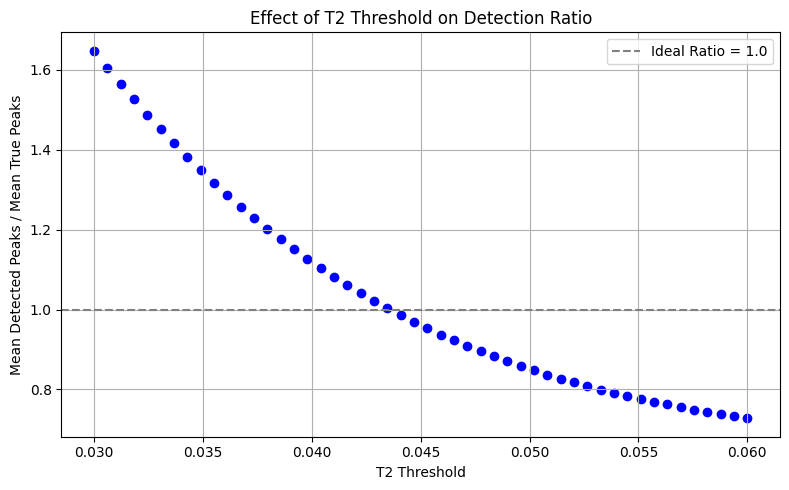

In [26]:

import matplotlib.pyplot as plt

true_peak_counts = np.count_nonzero(testdata['tag_values'], axis=1)
mean_true_peaks = np.mean(true_peak_counts)

print(f"T1 threshold: {T1:.4f}")


T2_values = np.linspace(0.03, 0.06, 50)
ratios = []

print("Scanning over T2 values...")
for T2 in tqdm(T2_values, desc="Scanning T2"):
    detected_peaks = numba_batched_derivative_peak_detection(testdata['wf_i'], T1, T2)
    detected_peak_counts = [len(peaks) for peaks in detected_peaks]
    mean_detected = np.mean(detected_peak_counts)
    ratio = mean_detected / mean_true_peaks if mean_true_peaks > 0 else 0
    ratios.append(ratio)


plt.figure(figsize=(8, 5))
plt.scatter(T2_values, ratios, color='blue')
plt.axhline(y=1.0, color='gray', linestyle='--', label='Ideal Ratio = 1.0')
plt.xlabel("T2 Threshold")
plt.ylabel("Mean Detected Peaks / Mean True Peaks")
plt.title("Effect of T2 Threshold on Detection Ratio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

T1 threshold: 0.0760
Scanning over T2 values...


Scanning T2:   0%|          | 0/10 [00:00<?, ?it/s]

Scanning T2: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


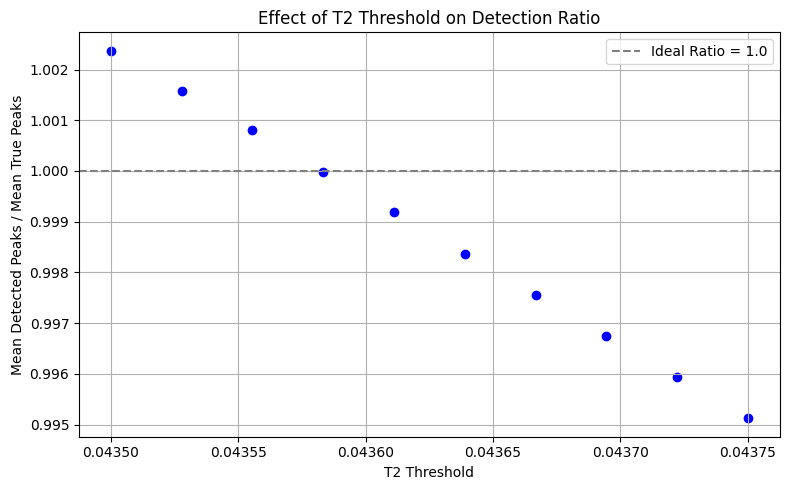

In [42]:

import matplotlib.pyplot as plt

true_peak_counts = np.count_nonzero(testdata['tag_values'], axis=1)
mean_true_peaks = np.mean(true_peak_counts)

print(f"T1 threshold: {T1:.4f}")


T2_values = np.linspace(0.0435, 0.04375, 10)
ratios = []

print("Scanning over T2 values...")
for T2 in tqdm(T2_values, desc="Scanning T2"):
    detected_peaks = numba_batched_derivative_peak_detection(testdata['wf_i'], T1, T2)
    detected_peak_counts = [len(peaks) for peaks in detected_peaks]
    mean_detected = np.mean(detected_peak_counts)
    ratio = mean_detected / mean_true_peaks if mean_true_peaks > 0 else 0
    ratios.append(ratio)


plt.figure(figsize=(8, 5))
plt.scatter(T2_values, ratios, color='blue')
plt.axhline(y=1.0, color='gray', linestyle='--', label='Ideal Ratio = 1.0')
plt.xlabel("T2 Threshold")
plt.ylabel("Mean Detected Peaks / Mean True Peaks")
plt.title("Effect of T2 Threshold on Detection Ratio")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
T2_values[np.argmin(np.abs(np.array(ratios) - 1.0))]

0.04358333333333333

Processing waveforms: 100%|██████████| 20000/20000 [00:15<00:00, 1276.34waveform/s]


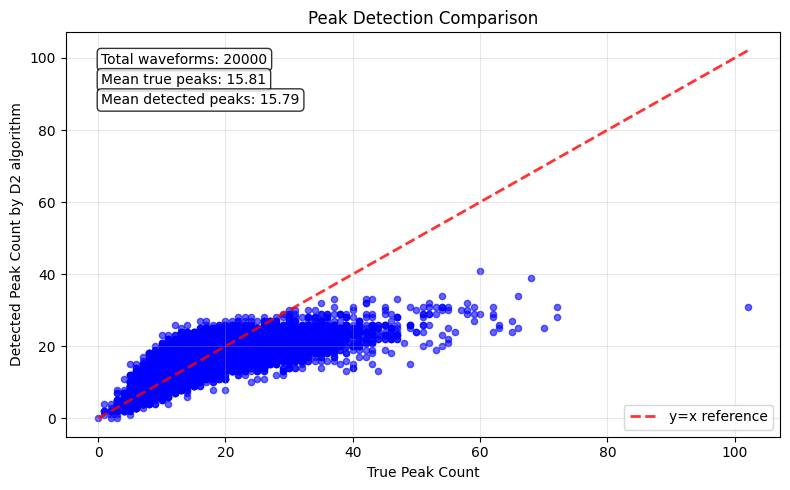

Correlation between true and detected peaks: 0.738
Standard deviation of true peaks: 6.99
Standard deviation of detected peaks: 4.53
Mean difference (detected - true): -0.02
Standard deviation of differences: 4.76
Mean absolute error: 3.27


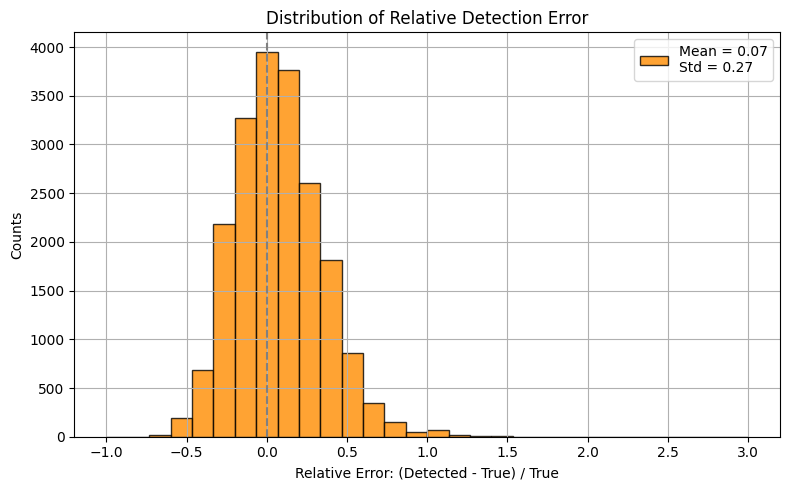

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

T1 = 0.0759587
T2 = 0.0435833

plt.figure(figsize=(8, 5))

detected_peaks = process_waveforms(testdata['wf_i'][:20000], T1, T2)
detected_peak_counts = [len(peaks) for peaks in detected_peaks]
true_peak_counts = np.count_nonzero(testdata['tag_values'][:20000], axis=1)

# Create scatter plot
plt.scatter(true_peak_counts, detected_peak_counts, alpha=0.6, s=20, color='blue')

# Add y=x reference line
max_val = max(np.max(true_peak_counts), np.max(detected_peak_counts))
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, label='y=x reference')

# Calculate correlation
correlation = np.corrcoef(true_peak_counts, detected_peak_counts)[0, 1]

plt.xlabel('True Peak Count')
plt.ylabel('Detected Peak Count by D2 algorithm')
plt.title(f'Peak Detection Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Add some statistics as text
plt.text(0.05, 0.95, f'Total waveforms: {len(true_peak_counts)}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.text(0.05, 0.90, f'Mean true peaks: {np.mean(true_peak_counts):.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.text(0.05, 0.85, f'Mean detected peaks: {np.mean(detected_peak_counts):.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


# Show distribution of differences
differences = np.array(detected_peak_counts) - np.array(true_peak_counts)

print(f"Correlation between true and detected peaks: {correlation:.3f}")
print(f"Standard deviation of true peaks: {np.std(true_peak_counts):.2f}")
print(f"Standard deviation of detected peaks: {np.std(detected_peak_counts):.2f}")
print(f"Mean difference (detected - true): {np.mean(differences):.2f}")
print(f"Standard deviation of differences: {np.std(differences):.2f}")
print(f"Mean absolute error: {np.mean(np.abs(differences)):.2f}")

with np.errstate(divide='ignore', invalid='ignore'):
    relative_errors = np.true_divide(detected_peak_counts - true_peak_counts, true_peak_counts)
    relative_errors[~np.isfinite(relative_errors)] = np.nan 


valid_errors = relative_errors[~np.isnan(relative_errors)]
mean_error = np.mean(valid_errors)
std_error = np.std(valid_errors)


plt.figure(figsize=(8, 5))
plt.hist(valid_errors, bins=30, color='darkorange', edgecolor='black', alpha=0.8,
         label=f"Mean = {mean_error:.2f}\nStd = {std_error:.2f}")
plt.axvline(0, color='gray', linestyle='--') 
plt.xlabel("Relative Error: (Detected - True) / True")
plt.ylabel("Counts")
plt.title("Distribution of Relative Detection Error")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Best parameters
T1 = 0.0759587
T2 = 0.04358333

# FCA search

### Functions

In [46]:
# Fixed Clusterization Method

import matplotlib.pyplot as plt

def estimate_primary_from_cluster_window(detected_peaks, b, c, d):
   """
   Estimate the number of primary ionizations per waveform by merging nearby peaks in a sliding window.


   Args:
       detected_peaks (list of lists): List of peak positions (indices) per waveform.
       b (int): Number of units to look forward in time window.
       c (float): Normalization factor (divides peak count in window).
       d (float): Maximum number of peaks in window.
   Returns:
       list: Estimated number of primary ionizations (float) for each waveform.
   """
   estimated_counts = []


   for peaks in detected_peaks:


       peaks = sorted(peaks)
       remaining_peaks = peaks.copy()
       count = 0.0


       while remaining_peaks:
           current = remaining_peaks[0]
           window_start = current
           window_end = current + b


           cluster = [p for p in remaining_peaks if window_start <= p <= window_end]


           if len(cluster) <= c:
               count += 1
           elif d*c > len(cluster) > c:
               count += len(cluster) / c
           else:
               count += d


           remaining_peaks = [p for p in remaining_peaks if p not in cluster]


       estimated_counts.append(count)
   return estimated_counts


def collect_cluster_peaks(detected_peaks, b, c, d):
   """
   For each waveform, return a list of peak lists used in each cluster count step.


   Args:
       detected_peaks (list of lists): List of peak positions (indices) per waveform.
       b (int): Window size to look forward.
       c (float): Normalization factor.
       d (float): Maximum number of peaks allowed in window.
  
   Returns:
       list of lists: Each inner list contains the peak values used at each cluster step.
   """
   all_cluster_peaks = []


   for peaks in detected_peaks:
       peaks = sorted(peaks)
       remaining_peaks = peaks.copy()
       waveform_clusters = []


       while remaining_peaks:
           current = remaining_peaks[0]
           window_start = current


           window_end = current + b


           cluster = [p for p in remaining_peaks if window_start <= p <= window_end]


           # Determine how many peaks to take from this cluster
           if len(cluster) <= c:
               n = 1
           elif d * c > len(cluster) > c:
               n = int(len(cluster) / c)
           else:
               n = int(d)


           # Store the first n peaks in this cluster (or fewer if not enough)
           waveform_clusters.append(cluster[:n])
           remaining_peaks = [p for p in remaining_peaks if p not in cluster]


       all_cluster_peaks.append(waveform_clusters)


   return all_cluster_peaks


def find_best_indices_3d(data, mode="mean"):
   if mode == "mean":
       idx = np.unravel_index(np.argmin(np.abs(data)), data.shape)
   elif mode == "std":
       idx = np.unravel_index(np.argmin(data), data.shape)
   return idx


def plot_heatmap_2d_slice(data_3d, d_idx, title, x_labels, y_labels, x_name, y_name, cmap='viridis', highlight=None):
   data = data_3d[:, :, d_idx]
   plt.figure(figsize=(10, 6))
   im = plt.imshow(data, origin='lower', cmap=cmap,
                   extent=[x_labels[0], x_labels[-1], y_labels[0], y_labels[-1]],
                   aspect='auto')


   cbar = plt.colorbar(im, format="%.4f")
   cbar.ax.tick_params(labelsize=10)


   plt.xlabel(x_name)
   plt.ylabel(y_name)
   plt.title(f"{title} (d = {d_values[d_idx]})")


   if highlight:
       i, j, _ = highlight
       x_val = x_labels[j]
       y_val = y_labels[i]
       plt.plot(x_val, y_val, 'ro', markersize=8, label='Best Point')
       plt.legend()


   plt.tight_layout()
   plt.show()


### Search

In [47]:
T1 = 0.0759587
T2 = 0.0435833

detected_peaks = process_waveforms(testdata['wf_i'], T1, T2)
true_primary_peak_counts = np.sum(testdata['tag_values'] == 1, axis=1)

Processing waveforms: 100%|██████████| 100000/100000 [01:18<00:00, 1281.77waveform/s]


In [48]:
# Fixed Clusterization Method


b_values = np.arange(1, 100, 1)
c_values = np.arange(0.5, 3.0, 0.1)
d_values = np.arange(1, 6, 1)




mean_diff_map = np.zeros((len(b_values), len(c_values), len(d_values)))
std_diff_map = np.zeros((len(b_values), len(c_values), len(d_values)))


mean_diff_map_abs = np.zeros((len(b_values), len(c_values), len(d_values)))
std_diff_map_abs = np.zeros((len(b_values), len(c_values), len(d_values)))


num_events = 5000


for i, b in enumerate(tqdm(b_values, desc="Scanning b")):
   for j, c in enumerate(c_values):
       for k, d in enumerate(d_values):
           primary_counts_est = estimate_primary_from_cluster_window(detected_peaks[:num_events], b=b, c=c, d=d)
           primary_counts_est = np.array(primary_counts_est)


           abs_diff = primary_counts_est - true_primary_peak_counts[:num_events]
           mean_diff_map_abs[i, j, k] = np.mean(abs_diff)
           std_diff_map_abs[i, j, k] = np.std(abs_diff)


           with np.errstate(divide='ignore', invalid='ignore'):
               relative_errors = np.true_divide(
                   primary_counts_est - true_primary_peak_counts[:num_events],
                   true_primary_peak_counts[:num_events]
               )
               relative_errors[~np.isfinite(relative_errors)] = np.nan


           valid_errors = relative_errors[~np.isnan(relative_errors)]
           mean_diff_map[i, j, k] = np.mean(valid_errors)
           std_diff_map[i, j, k] = np.std(valid_errors)

Scanning b: 100%|██████████| 99/99 [06:29<00:00,  3.93s/it]


Best mean ~0 at b=68, c=0.7999999999999999, d=3 → mean = -0.0001, std = 0.2466
Best std min at b=99, c=0.5, d=1 → mean = -0.7085, std = 0.0861


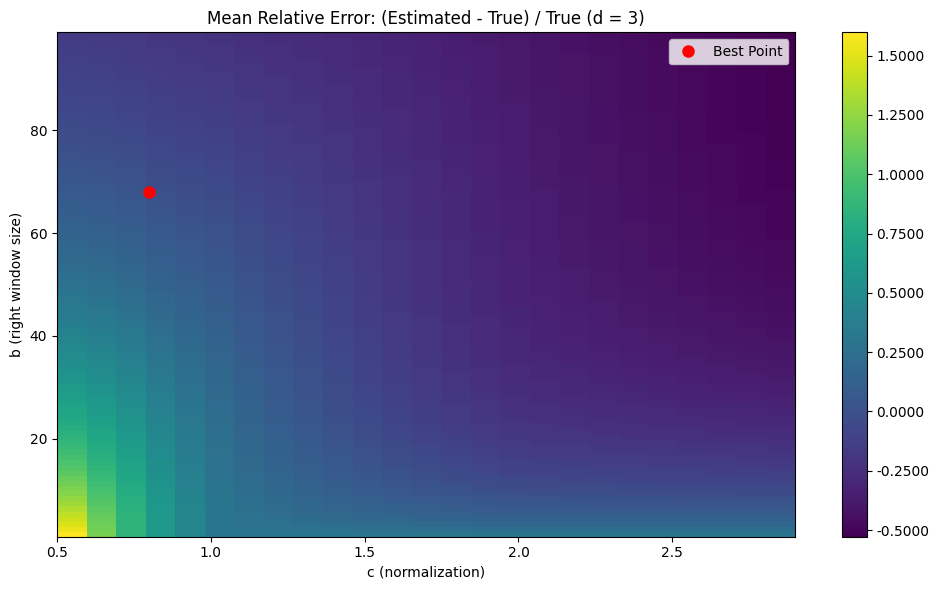

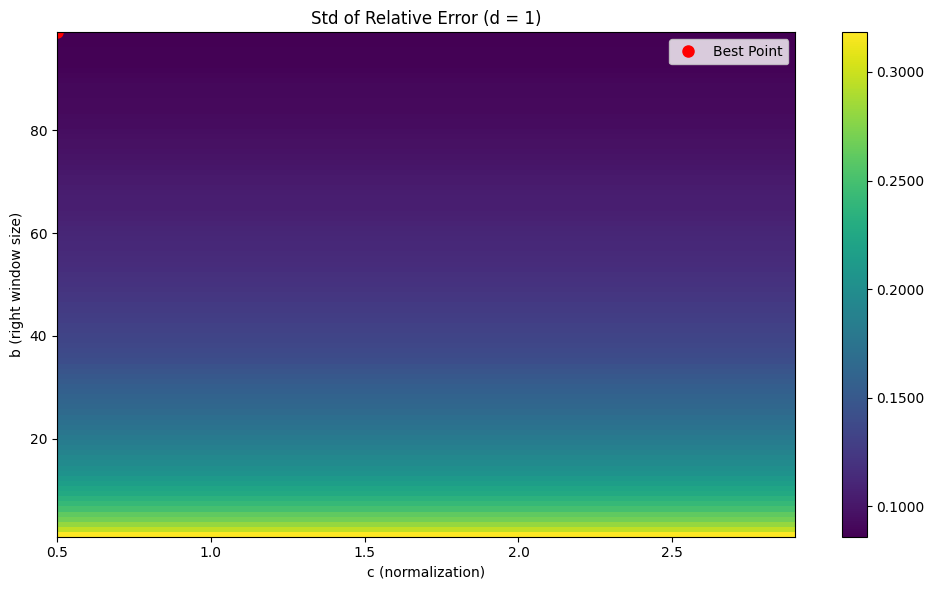

In [50]:
best_mean_idx = find_best_indices_3d(mean_diff_map, mode="mean")
best_std_idx = find_best_indices_3d(std_diff_map, mode="std")


best_mean_val = mean_diff_map[best_mean_idx]
best_std_val_at_mean = std_diff_map[best_mean_idx]
best_std_val = std_diff_map[best_std_idx]
best_mean_val_at_std = mean_diff_map[best_std_idx]


print(f"Best mean ~0 at b={b_values[best_mean_idx[0]]}, c={c_values[best_mean_idx[1]]}, d={d_values[best_mean_idx[2]]} "
     f"→ mean = {best_mean_val:.4f}, std = {best_std_val_at_mean:.4f}")


print(f"Best std min at b={b_values[best_std_idx[0]]}, c={c_values[best_std_idx[1]]}, d={d_values[best_std_idx[2]]} "
     f"→ mean = {best_mean_val_at_std:.4f}, std = {best_std_val:.4f}")


plot_heatmap_2d_slice(mean_diff_map, d_idx=best_mean_idx[2],
                     title="Mean Relative Error: (Estimated - True) / True",
                     x_labels=c_values, y_labels=b_values,
                     x_name="c (normalization)", y_name="b (right window size)",
                     highlight=best_mean_idx)


plot_heatmap_2d_slice(std_diff_map, d_idx=best_std_idx[2],
                     title="Std of Relative Error",
                     x_labels=c_values, y_labels=b_values,
                     x_name="c (normalization)", y_name="b (right window size)",
                     highlight=best_std_idx)


In [51]:
primary_counts_est = estimate_primary_from_cluster_window(detected_peaks[:num_events], b=43, c=0.8, d=3)
primary_counts_est = np.array(primary_counts_est)


error = (primary_counts_est - true_primary_peak_counts[:num_events]) / true_primary_peak_counts[:num_events]

In [53]:
np.std(error)

0.28227295040691874

# Best parameters:
b=68, c=0.7999999999999999, d=3

# ACA Search

### Functions

In [54]:
# Adaptive Clusterization Method

import itertools

region_bounds = {
        'r1': (0, 125),
        'r2': (125, 400),
        'r3': (400, 500)
    }

# region_bounds = {
    #     'r1': (0, 130),
    #     'r2': (130, 1600),
    #     'r3': (1600, 3000),
    # }

def estimate_primary_from_cluster_window_adaptive(detected_peaks, b_map, c_map, d_map):
    """
    Adaptive estimation of primary ionizations per waveform using different parameters for different time regions.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b_map, c_map, d_map (dict): Keys are region names ('r1', 'r2', ...), values are parameter values.
    
    Returns:
        list: Estimated primary ionizations per waveform.
    """
    estimated_counts = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        count = 0.0

        while remaining_peaks:
            current = remaining_peaks[0]

            # Determine region
            region = next(r for r, (low, high) in region_bounds.items() if low <= current < high)
            b = b_map[region]
            c = c_map[region]
            d = d_map[region]

            window_start = current
            window_end = current + b
            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                count += 1
            elif d * c > len(cluster) > c:
                count += len(cluster) / c
            else:
                count += d

            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        estimated_counts.append(count)
    return estimated_counts


def collect_cluster_peaks_adaptive(detected_peaks, b_map, c_map, d_map):
    """
    Collect cluster peaks per waveform with region-adapted parameters.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b_map, c_map, d_map (dict): Region-specific parameter mappings.

    Returns:
        list of lists: Each inner list contains peak lists used in each cluster.
    """
    all_cluster_peaks = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        waveform_clusters = []

        while remaining_peaks:
            current = remaining_peaks[0]

            region = next(r for r, (low, high) in region_bounds.items() if low <= current < high)
            b = b_map[region]
            c = c_map[region]
            d = d_map[region]

            window_start = current
            window_end = current + b
            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                n = 1
            elif d * c > len(cluster) > c:
                n = int(len(cluster) / c)
            else:
                n = int(d)

            waveform_clusters.append(cluster[:n])
            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        all_cluster_peaks.append(waveform_clusters)

    return all_cluster_peaks

def scan_adaptive_parameters_region_wise(detected_peaks, true_primary_peaks):
    """
    Scan optimal parameters for each region using true primary peaks.
    
    Args:
        detected_peaks (list): List of detected peak positions for each waveform
        true_primary_peaks (list): List of true primary peak positions for each waveform (from extract_true_primary_peaks_from_labels)
    """

    b_values = np.arange(1, 100, 1)
    c_values = np.arange(0.8, 2.0, 0.1)
    d_values = np.arange(1, 6, 1)
    
    best_params = {}
    region_results = {}
    
    for region, (low, high) in region_bounds.items():
        print(f"Scanning parameters for region {region} ({low}-{high})")
        
        region_detected_peaks = []
        region_true_counts = []
        
        for i, peaks in enumerate(detected_peaks):
            region_peaks = [p for p in peaks if low <= p < high]
            true_peaks_in_region = [p for p in true_primary_peaks[i] if low <= p < high]
            true_count_in_region = len(true_peaks_in_region)
            if region_peaks:
                region_detected_peaks.append(region_peaks)
                region_true_counts.append(true_count_in_region)
        
        if not region_detected_peaks:
            best_params[region] = {'b': 10, 'c': 1.0, 'd': 2}
            region_results[region] = float('inf')
            print(f"No detected peaks in region {region}, using default parameters")
            continue
        
        region_true_counts = np.array(region_true_counts)
        
        best_score = float('inf')
        best_region_params = None
        
        for b, c, d in tqdm(list(itertools.product(b_values, c_values, d_values)), 
                           desc=f"Region {region}"):
            
            temp_b_map = {r: 10 for r in region_bounds.keys()}
            temp_c_map = {r: 1.0 for r in region_bounds.keys()}
            temp_d_map = {r: 2 for r in region_bounds.keys()}
            
            temp_b_map[region] = int(b)
            temp_c_map[region] = float(c)
            temp_d_map[region] = int(d)
            
            estimated_counts = []
            for peaks in region_detected_peaks:
                count = estimate_single_region_count(peaks, b, c, d)
                estimated_counts.append(count)
            
            estimated_counts = np.array(estimated_counts)
            
            # Calculate relative errors: (estimated - true) / true
            with np.errstate(divide='ignore', invalid='ignore'):
                relative_errors = (estimated_counts - region_true_counts) / region_true_counts
                # Handle division by zero and invalid values
                relative_errors = relative_errors[np.isfinite(relative_errors)]
            
            # Calculate score based on relative errors
            if len(relative_errors) > 0:
                score = np.abs(np.mean(relative_errors))  # Mean squared relative error
            else:
                score = float('inf')  # If no valid relative errors, set high score
            
            if score < best_score:
                best_score = score
                best_region_params = {'b': b, 'c': c, 'd': d}
                # print(f"Best score: {score:.4f}")
                # print(f"Best params: {best_region_params}")
        
        best_params[region] = best_region_params
        region_results[region] = best_score
        print(f"Best params for {region}: {best_region_params}, Score: {best_score:.4f}")
    
    return best_params, region_results

def estimate_single_region_count(peaks, b, c, d):
    if not peaks:
        return 0.0
    
    peaks = sorted(peaks)
    remaining_peaks = peaks.copy()
    count = 0.0
    
    while remaining_peaks:
        current = remaining_peaks[0]
        window_start = current
        window_end = current + b
        
        cluster = [p for p in remaining_peaks if window_start <= p <= window_end]
        
        if len(cluster) <= c:
            count += 1
        elif d * c > len(cluster) > c:
            count += len(cluster) / c
        else:
            count += d
        
        remaining_peaks = [p for p in remaining_peaks if p not in cluster]
    
    return count

def run_adaptive_parameter_optimization(detected_peak, true_primary_peaks):
    """Complete adaptive parameter optimization workflow"""
    
    print("Starting adaptive parameter scanning...")
    
    # Step 1: Parameter scanning
    best_params, region_results = scan_adaptive_parameters_region_wise(
        detected_peak, 
        true_primary_peaks
    )
    
    # Step 2: Format conversion
    b_map = {region: params['b'] for region, params in best_params.items()}
    c_map = {region: params['c'] for region, params in best_params.items()}
    d_map = {region: params['d'] for region, params in best_params.items()}
    
    # Step 3: Final prediction
    adaptive_estimates = estimate_primary_from_cluster_window_adaptive(
        detected_peak, b_map, c_map, d_map
    )
    
    # Step 4: Compare with fixed parameter method
    # Use default fixed parameters
    fixed_estimates = estimate_primary_from_cluster_window(
        detected_peak, b=8, c=2.8999999999999995, d=2 
    )
    # fixed_estimates = estimate_primary_from_cluster_window(
    #     detected_peak, b=69, c=0.899, d=3
    # )

    true_primary_peak_counts = [len(peaks) for peaks in true_primary_peaks]
    true_primary_peak_counts = np.array(true_primary_peak_counts)
    adaptive_estimates = np.array(adaptive_estimates)
    fixed_estimates = np.array(fixed_estimates)
    
    
    # Step 5: Performance comparison
    adaptive_mae = np.mean(np.abs(adaptive_estimates - true_primary_peak_counts))
    fixed_mae = np.mean(np.abs(fixed_estimates - true_primary_peak_counts))
    
    print(f"\nPerformance comparison:")
    print(f"Adaptive method MAE: {adaptive_mae:.4f}")
    print(f"Fixed parameter method MAE: {fixed_mae:.4f}")
    print(f"Improvement: {((fixed_mae - adaptive_mae) / fixed_mae * 100):.2f}%")
    
    # Step 6: Visualization
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Parameter distribution
    plt.subplot(2, 2, 1)
    regions = list(best_params.keys())
    b_values = [best_params[r]['b'] for r in regions]
    plt.bar(regions, b_values)
    plt.title('Optimal b parameters by region')
    plt.ylabel('b value')
    
    plt.subplot(2, 2, 2)
    c_values = [best_params[r]['c'] for r in regions]
    plt.bar(regions, c_values)
    plt.title('Optimal c parameters by region')
    plt.ylabel('c value')
    
    # Subplot 3: Prediction comparison
    plt.subplot(2, 2, 3)
    adaptive_corr = np.corrcoef(true_primary_peak_counts, adaptive_estimates)[0, 1]
    fixed_corr = np.corrcoef(true_primary_peak_counts, fixed_estimates)[0, 1]

    plt.scatter(true_primary_peak_counts, adaptive_estimates, alpha=0.6, label=f'Adaptive (R={adaptive_corr:.3f})')
    plt.scatter(true_primary_peak_counts, fixed_estimates, alpha=0.6, label=f'Fixed (R={fixed_corr:.3f})')
    plt.plot([0, max(true_primary_peak_counts)], [0, max(true_primary_peak_counts)], 'r--')
    plt.xlabel('True Counts')
    plt.ylabel('Estimated Counts')
    plt.legend()
    plt.title('Prediction accuracy comparison')
    
    # Subplot 4: Error distribution
    plt.subplot(2, 2, 4)
    with np.errstate(divide='ignore', invalid='ignore'):
        adaptive_rel_errors = (np.array(adaptive_estimates) - true_primary_peak_counts) / true_primary_peak_counts
        fixed_rel_errors = (np.array(fixed_estimates) - true_primary_peak_counts) / true_primary_peak_counts
        adaptive_rel_errors = adaptive_rel_errors[np.isfinite(adaptive_rel_errors)]
        fixed_rel_errors = fixed_rel_errors[np.isfinite(fixed_rel_errors)]

    # Calculate mean and std for relative errors
    adaptive_rel_mean = np.mean(adaptive_rel_errors)
    adaptive_rel_std = np.std(adaptive_rel_errors)
    fixed_rel_mean = np.mean(fixed_rel_errors)
    fixed_rel_std = np.std(fixed_rel_errors)

    plt.hist(adaptive_rel_errors, bins=100, alpha=0.6, range=(-1, 2), label=f'Adaptive (μ={adaptive_rel_mean:.3f}, σ={adaptive_rel_std:.3f})', density=False)
    plt.hist(fixed_rel_errors, bins=100, alpha=0.6, range=(-1, 2), label=f'Fixed (μ={fixed_rel_mean:.3f}, σ={fixed_rel_std:.3f})', density=False)
    plt.xlabel('Relative Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Relative error distribution comparison')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'best_params': best_params,
        'b_map': b_map,
        'c_map': c_map,
        'd_map': d_map,
        'adaptive_estimates': adaptive_estimates,
        'region_results': region_results
    }

In [55]:
region_bounds


{'r1': (0, 125), 'r2': (125, 400), 'r3': (400, 500)}

### Search

In [56]:
T1 = 0.0759587
# # T2 = 0.0435264
# T2 = 0.04346938
T2 = 0.0435833
detected_peaks = process_waveforms(testdata['wf_i'][:10000], T1, T2)

Processing waveforms: 100%|██████████| 10000/10000 [00:08<00:00, 1170.71waveform/s]


Extracting true primary peaks from labels (vectorized)...


Processing waveforms: 100%|██████████| 100000/100000 [00:00<00:00, 480527.01waveform/s]


Starting adaptive parameter scanning...
Scanning parameters for region r1 (0-125)


Region r1: 100%|██████████| 5940/5940 [00:04<00:00, 1199.52it/s]


Best params for r1: {'b': 4, 'c': 0.9, 'd': 2}, Score: 0.0010
Scanning parameters for region r2 (125-400)


Region r2: 100%|██████████| 5940/5940 [02:21<00:00, 41.89it/s]


Best params for r2: {'b': 30, 'c': 1.2999999999999998, 'd': 5}, Score: 0.0000
Scanning parameters for region r3 (400-500)


Region r3: 100%|██████████| 5940/5940 [00:43<00:00, 137.53it/s]


Best params for r3: {'b': 91, 'c': 1.7999999999999998, 'd': 2}, Score: 0.0014

Performance comparison:
Adaptive method MAE: 2.2129
Fixed parameter method MAE: 2.1903
Improvement: -1.03%


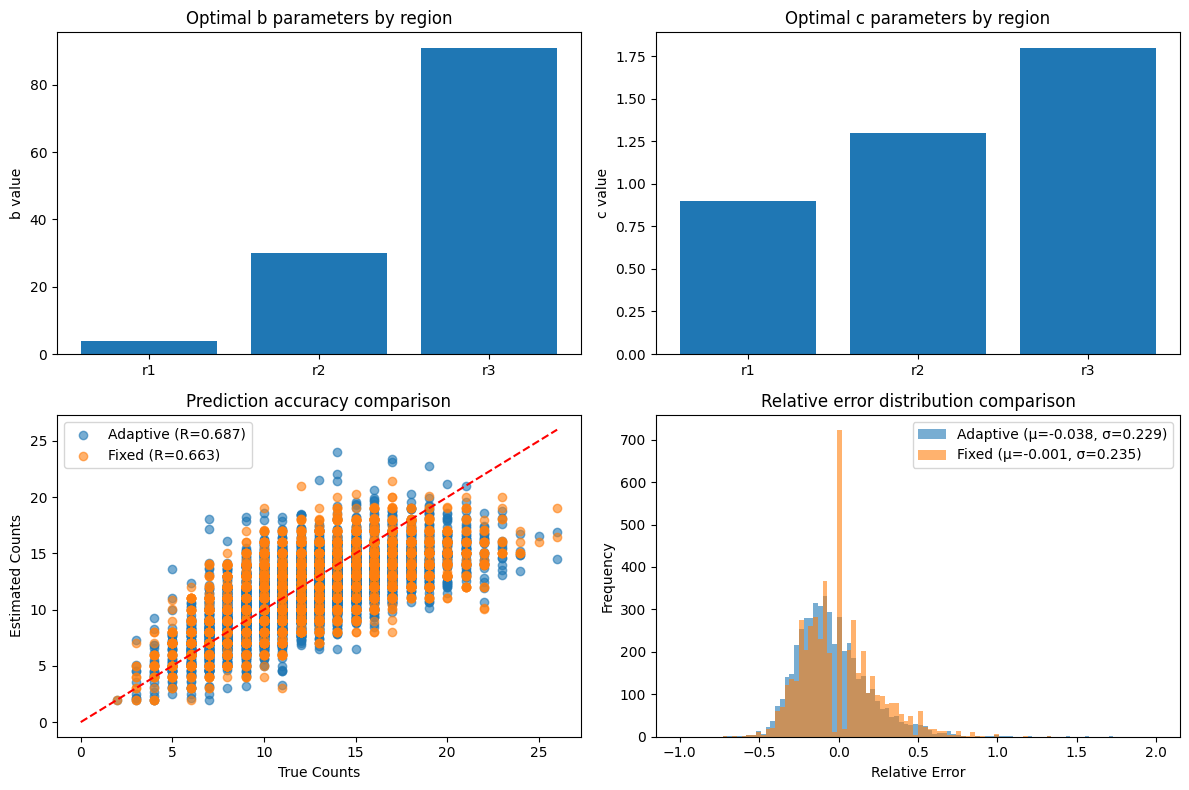

In [57]:
true_primary_peaks = extract_true_primary_peaks_from_labels(testdata)
results = run_adaptive_parameter_optimization(detected_peaks[:5000], true_primary_peaks[:5000])

# Best parameters:

region_bounds = {
    'r1': (0, 125),
    'r2': (125, 380),
    'r3': (400, 500)
}

best_params = {
    'r1': {'b': 4, 'c': 0.9, 'd': 2},
    'r2': {'b': 30, 'c': 1.2999999999999998, 'd': 5},
    'r3': {'b': 91, 'c': 1.7999999999999998, 'd': 2}
}